In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import networkx as nx

from matplotlib import pyplot as plt
from sklearn import model_selection

import codecs
import json
import os

import node2vec

In [6]:
IMPORT = True
EXPORT = True
DISPLAY = True
VERBOSE = False
DATA_DIR = "new_data"
SEED = 221

In [7]:
def get_datasets(type='medium'):
    if type not in ['medium', 'all', 'mini']:
        raise Exception("Invalid type!")
        
    train_df = pd.read_csv(DATA_DIR + f'/train_{type}.csv').set_index("request_id")
    dev_df = pd.read_csv(DATA_DIR + f'/val_{type}.csv').set_index("request_id")
    return train_df, dev_df

In [8]:
train_df, dev_df = get_datasets('medium')

In [9]:
df = dev_df
G = nx.Graph()
import ast

for i, row in df.iterrows():
    username = row.requester_username
    pizza = row.requester_received_pizza
    subreddits = row.requester_subreddits_at_request
    for subreddit in ast.literal_eval(str(subreddits)):
        G.add_edge(username, subreddit)

In [10]:
# ## Connectivity
# One more preprocessing step - get rid of extra disconnected components
nx.number_connected_components(G)
for component in nx.connected_components(G):
    print(len(component))
    if len(component) < 10:
        print(component)
print(len(G))
G = G.subgraph(next(nx.connected_components(G))).copy()
print(len(G))

2315
2315
2315


In [11]:
pos = nx.drawing.layout.bipartite_layout(G, list(df.requester_username))

In [12]:
requesters = list(df.requester_username.unique())
subreddits = [n for n in G.nodes() if n not in requesters]

In [13]:
len(requesters), len(subreddits), len(G.nodes())

(90, 2225, 2315)

## node2vec

In [14]:
import networkx as nx
from node2vec import Node2Vec

# Create a graph
graph = G

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `diemnsions` and `workers` are automatically passed (from the Node2Vec constructor)

Computing transition probabilities: 100%|██████████| 2315/2315 [00:01<00:00, 1646.27it/s]


KeyError: "word '2' not in vocabulary"

In [23]:
EMBEDDING_FILENAME = "pizza_embeddings.emb"
EMBEDDING_MODEL_FILENAME = 'pizza_embeddings.model'
EDGES_EMBEDDING_FILENAME = "pizza_embeddings_edges.emb"

In [27]:


# Look for most similar nodes
model.wv.most_similar(requesters[0])  # Output node names are always strings

[('Birbs', 0.65260910987854),
 ('collapse', 0.6473907232284546),
 ('ehlersdanlos', 0.6449336409568787),
 ('EggsInStrangePlaces', 0.6398988962173462),
 ('ChronicPain', 0.6390657424926758),
 ('curlyhair', 0.636577308177948),
 ('castiron', 0.6278549432754517),
 ('specializedtools', 0.6272625923156738),
 ('microbiology', 0.6264528036117554),
 ('ActLikeYouBelong', 0.6223186254501343)]

In [16]:


# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

In [20]:
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('dity4u', 'webcomics')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

Generating edge features: 100%|██████████| 2680770/2680770.0 [00:15<00:00, 174448.57it/s]


KeyError: "word '('1', '2')' not in vocabulary"

In [24]:
# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('dity4u', 'webcomics')))


# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Generating edge features: 100%|██████████| 2680770/2680770.0 [00:15<00:00, 174599.21it/s]


In [26]:
edges_kv.most_similar(str(('dity4u', 'webcomics')))

[("('LiveFromNewYork', 'dity4u')", 0.9920370578765869),
 ("('EggsInStrangePlaces', 'dity4u')", 0.9866383075714111),
 ("('Birbs', 'dity4u')", 0.9857255220413208),
 ("('dity4u', 'milwaukee')", 0.985491156578064),
 ("('ActLikeYouBelong', 'dity4u')", 0.9849276542663574),
 ("('dity4u', 'microbiology')", 0.9847844839096069),
 ("('castiron', 'dity4u')", 0.9846010208129883),
 ("('dity4u', 'sewing')", 0.9841004610061646),
 ("('dity4u', 'optometry')", 0.9832825660705566),
 ("('dity4u', 'shoemaking')", 0.9818261861801147)]

## Link prediction

In [ ]:
resource_allocation_index(G[, ebunch])	Compute the resource allocation index of all node pairs in ebunch.
jaccard_coefficient(G[, ebunch])	Compute the Jaccard coefficient of all node pairs in ebunch.
adamic_adar_index(G[, ebunch])	Compute the Adamic-Adar index of all node pairs in ebunch.
preferential_attachment(G[, ebunch])	Compute the preferential attachment score of all node pairs in ebunch.
cn_soundarajan_hopcroft(G[, ebunch, community])	Count the number of common neighbors of all node pairs in ebunch using community information.
ra_index_soundarajan_hopcroft(G[, ebunch, ...])	Compute the resource allocation index of all node pairs in ebunch using community information.
within_inter_cluster(G[, ebunch, delta, ...])	Compute the ratio of within- and inter-cluster common neighbors of all node pairs in ebunch.

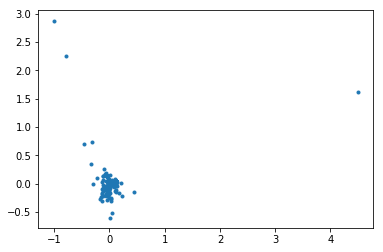

In [51]:
# ## Spectral analysis
node_ordering = G.nodes()
Adj = nx.linalg.adjacency_matrix(G)


# Spectral Clustering
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components=2,
                              affinity='precomputed',
                              random_state=SEED,
                              n_neighbors=None,
                              n_jobs=None)
spectral_embedding = model.fit_transform(Adj.toarray())

if (DISPLAY):
    # plot Spectral Clustering
    plt.scatter(spectral_embedding[:,0], spectral_embedding[:, 1])
    plt.show()

In [97]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, perplexity=100.0, early_exaggeration=12.0,
             learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
             min_grad_norm=1e-07, random_state=SEED)
embedding = model.fit_transform(spectral_embedding)


embedding = pd.DataFrame(embedding, index=node_ordering)
embedding.head()

,0,1
dity4u,20.768450,14.249822
webcomics,9.548995,-2.714774
funny,18.843052,12.793925
Birbs,9.556873,-2.684278
ehlersdanlos,9.507523,-2.788154


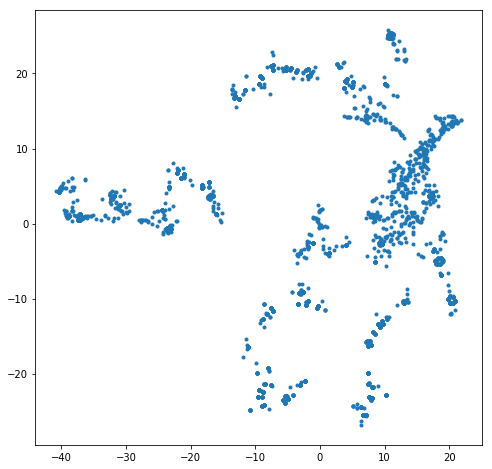

In [98]:
if (DISPLAY):
    # plot t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding.iloc[:,0], embedding.iloc[:, 1])
    plt.show()

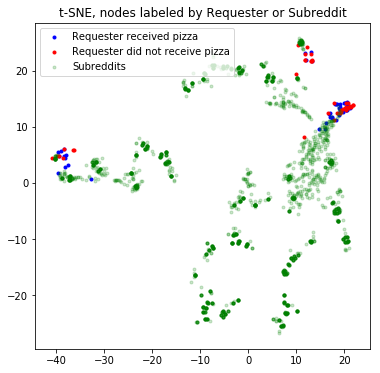

In [101]:
if (DISPLAY):
    plt.figure(figsize=(6, 6))
    plt.rcParams["scatter.marker"] = '.'
    group1 = df[df.requester_received_pizza == 1].requester_username.unique()
    group2 = df[df.requester_received_pizza == 0].requester_username.unique()
    
    group3 = subreddits
    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=1.0, label="Requester received pizza", marker='.', color='b')
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=1.0, label="Requester did not receive pizza", marker='.', color='r')
    plt.scatter(embedding.loc[group3].iloc[:,0],
                embedding.loc[group3].iloc[:,1], alpha=0.2, label="Subreddits", marker='.', color='g')
    plt.legend()
    plt.title("t-SNE, nodes labeled by Requester or Subreddit")
    plt.show()

# Naive baseline

In [55]:
adj_features = pd.DataFrame(Adj.toarray(), index=node_ordering, columns=node_ordering)

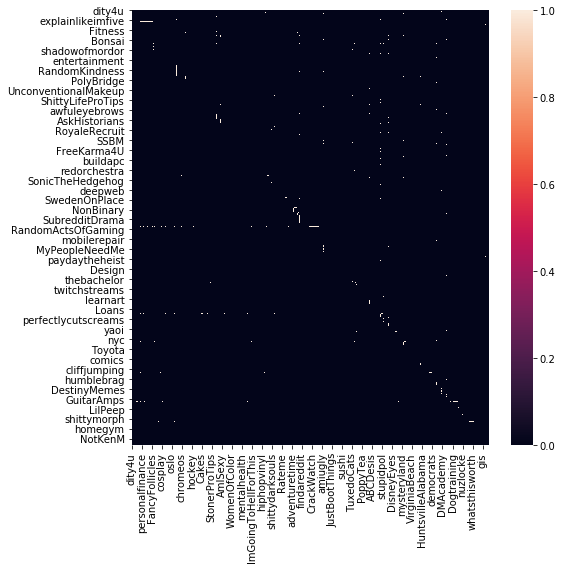

In [56]:
plt.figure(figsize=(8, 8))
sns.heatmap(adj_features)

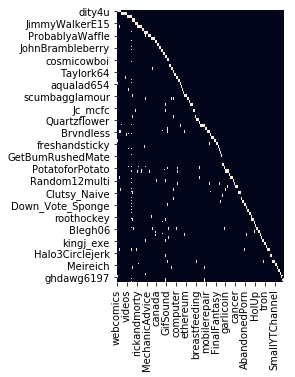

In [103]:
plt.figure(figsize=(3, 5))
sns.heatmap(adj_features.loc[requesters][subreddits].dropna(axis=0), cbar=False)

In [58]:
X = adj_features.loc[df.requester_username][subreddits]
X['received_pizza'] = df.set_index('requester_username').requester_received_pizza

In [59]:
dat = X.dropna(axis=0).dropna(how='all', axis=1)

In [ ]:
X_train = dat[[col for col in dat.columns if col != 'received_pizza']]
y_train = dat['received_pizza']

In [60]:
X_dev = dat[[col for col in dat.columns if col != 'received_pizza']]
y_dev = dat['received_pizza']

In [61]:
lr = sklearn.linear_model.LogisticRegression()

In [70]:
all_subreddits = X_train.columns.union(X_dev.columns)
X_train = pd.concat([X_train, pd.DataFrame(columns=[col for col in all_subreddits if col not in X_train.columns])])
X_dev = pd.concat([X_dev, pd.DataFrame(columns=[col for col in all_subreddits if col not in X_dev.columns])])

In [76]:
X_train = X_train[all_subreddits].fillna(value=0)
X_dev = X_dev[all_subreddits].fillna(value=0)

In [84]:
(X_train.columns == X_dev.columns).all()

True

In [79]:
lr.fit(X_train, y_train)
lr.score(X_dev, y_dev)

0.5222222222222223

In [80]:
y_pred = lr.predict(X_dev)

In [81]:
sklearn.metrics.roc_auc_score(y_dev, y_pred)

0.4838056680161943

In [82]:
sklearn.metrics.accuracy_score(y_dev, y_pred)

0.5222222222222223

In [86]:
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)

In [87]:
communities

<generator object label_propagation_communities at 0x7f8d7fa10eb8>

In [89]:
for c in communities:
    print(c)

{'Dukedyduke', 'thinkpad', 'beerporn', 'creepyPMs', 'freedompop', 'Ooer', 'transgamers', 'ftmcirclejerk', 'FTMMen', 'ftm', 'dragonsfuckingcars', 'lgbt', 'doujinshi', 'relationship_advice', 'ffxiv', 'u_Dukedyduke', 'transpassing', 'StardewValley', 'HENTAI_GIF', 'Bestbuy', 'NoTraps', 'Sneks', 'gfur', 'AndroidQuestions', 'transgendercirclejerk', 'sadcats', 'perfectlycutscreams', 'Louisville', 'GameSale', 'gay_irl', 'transtimelines', 'askgaybros', 'beer', 'gatekeeping', 'grilledcheese', 'vnsuggest', 'blurrypicturesofcats', 'preyingmantis', 'gamecollecting', 'amiugly', 'creepyasterisks'}
{'netflix', 'buildapcforme', 'AskTrumpSupporters', 'Korean', 'LivestreamFail', 'MLBTheShow', 'Beck4', 'Dungeons_and_Dragons', 'mlb', 'SuggestALaptop', 'dndnext', 'DungeonsAndDragons', 'criticalrole', 'warcraftlore', 'cellphones', 'Smartphones'}
{'GaySoundsShitposts', 'UnsolvedMysteries', 'wheredidthesodago', '2meirl4meirl', 'nonononoyes', 'mylittlepony', 'furry_irl', 'onetruegod', 'MetalMemes', 'AgainstHate